# Example 10: Physics-Informed Neural Networks (PINN)

This example demonstrates how to train physics-informed RNNs for system
identification. Two approaches are shown:

1. **Basic RNN with collocation points** -- trained purely on physics
   constraints, with no measured data fitting at all. The model learns to
   satisfy the governing ODE on randomly generated excitation signals.
2. **PIRNN (Physics-Informed RNN)** -- combines data fitting with physics
   constraints and supports variable initial conditions via a StateEncoder.

Both approaches embed the system's governing equations directly into the
training loss, so the model is guided by physical laws rather than relying
solely on data.

## Prerequisites

- [Example 00: Your First Model](00_your_first_model.ipynb)
- [Example 01: Understanding the Data Pipeline](01_data_pipeline.ipynb)
- [Example 02: Simulation](02_simulation.ipynb)
- [Example 03: Prediction -- Using Output Feedback](03_prediction.ipynb)
- [Example 04: Benchmark RNN](04_benchmark_rnn.py)

## Setup

In [1]:
from pathlib import Path

from tsfast.datasets.core import create_dls
from tsfast.models.rnn import RNNLearner
from tsfast.pinn.core import (
    CollocationPointsCB,
    PhysicsLossCallback,
    generate_excitation_signals,
    diff1_forward,
)
from tsfast.pinn.pirnn import PIRNNLearner
from tsfast.learner.losses import fun_rmse, zero_loss

## The Spring-Damper System

We model a mass-spring-damper system governed by the second-order ODE:

```
m * a + c * v + k * x = u
```

where:

- **m** = mass
- **c** = damping coefficient
- **k** = spring constant
- **x** = position, **v** = velocity, **a** = acceleration
- **u** = external force (the input signal)

The system has **1 input** (force u) and **2 outputs** (position x,
velocity v). Our goal is to train a neural network that respects this
physical law.

## Physical Parameters and Physics Loss

The physics loss function encodes the governing ODE as a training
objective. It receives the model's input `u`, predictions `y_pred`, and
(optionally) reference data `y_ref`, and returns a dictionary of loss
components:

- **`physics`**: residual of the ODE -- should be zero if the model
  perfectly satisfies `ma + cv + kx = u`
- **`derivative`**: consistency between velocity v and the numerical
  derivative of position dx/dt
- **`initial`**: penalizes deviation from measured initial conditions
  (only when reference data `y_ref` is available)

In [2]:
MASS = 1.0
SPRING_CONSTANT = 1.0
DAMPING_COEFFICIENT = 0.1
DT = 0.01


def spring_damper_physics(u, y_pred, y_ref):
    """Physics loss for the spring-damper ODE: ma + cv + kx = u."""
    x, v = y_pred[:, :, 0], y_pred[:, :, 1]
    u_force = u[:, :, 0]

    a = diff1_forward(v, DT)
    dx_dt = diff1_forward(x, DT)

    loss = {
        'physics': ((MASS * a + DAMPING_COEFFICIENT * v + SPRING_CONSTANT * x - u_force) ** 2).mean(),
        'derivative': ((v - dx_dt) ** 2).mean(),
    }

    if y_ref is not None:
        init_sz = 10
        loss['initial'] = ((x[:, :init_sz] - y_ref[:, :init_sz, 0]) ** 2).mean()

    return loss

## Load the PINN Dataset

This example uses a locally bundled dataset in `test_data/pinn/`
(no download needed). The HDF5 files contain three datasets: `u` (force),
`x` (position), and `v` (velocity).

We use a robust path resolution that works whether the code runs as a
notebook (from `examples/notebooks/`) or as a script (from
`examples/scripts/`).

In [3]:
def _find_project_root(marker: str = "test_data") -> Path:
    """Walk up from script/notebook location to find the project root."""
    try:
        start = Path(__file__).resolve().parent
    except NameError:
        start = Path(".").resolve()
    p = start
    while p != p.parent:
        if (p / marker).is_dir():
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find '{marker}' directory above {start}")


_root = _find_project_root()
path = _root / "test_data" / "pinn"

Key parameters:

- **`u=['u'], y=['x', 'v']`** -- column names matching the HDF5 dataset
  keys
- **`win_sz=100`** -- short windows because the PINN dataset has short
  trajectories (500 samples at 100 Hz = 5 seconds)
- **`stp_sz=1, valid_stp_sz=1`** -- step size of 1 gives maximum overlap
  between windows for more training data
- **`n_batches_train=300`** -- fixed number of training batches per epoch,
  important for PINN training where we want many gradient steps per epoch
- **`.cpu()`** -- PINN training is lightweight, CPU is sufficient

In [4]:
dls = create_dls(
    u=['u'], y=['x', 'v'],
    dataset=path,
    win_sz=100, stp_sz=1, valid_stp_sz=1,
    bs=32, n_batches_train=300,
).cpu()

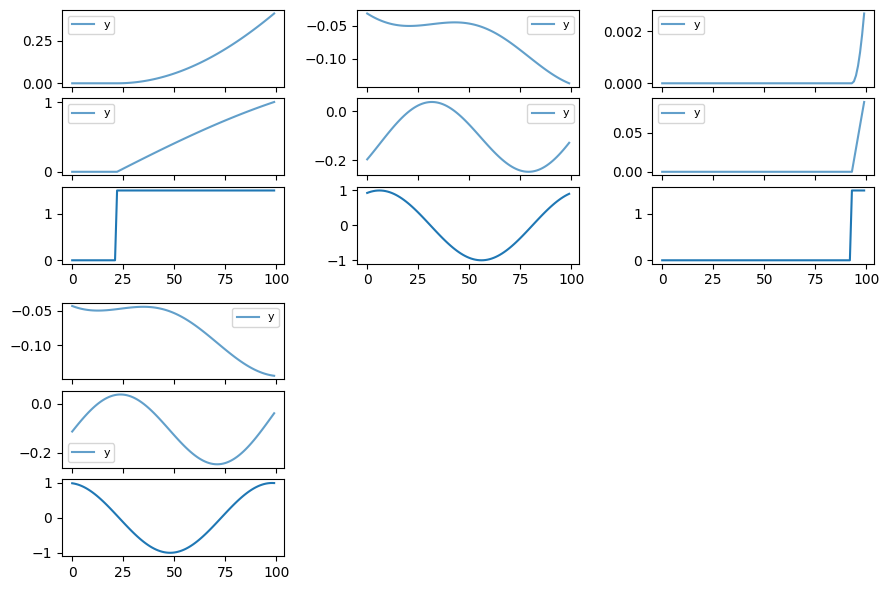

In [5]:
dls.show_batch(max_n=4)

## Approach 1: Basic RNN with Collocation Points

This trains a standard RNN using **only** physics constraints -- no data
fitting at all. The model learns to satisfy the ODE on randomly generated
excitation signals (collocation points). This is useful as a physics
surrogate model: it can simulate the spring-damper system for any input
signal without ever having seen measured data.

Key design choices:

- **`zero_loss`** as the data loss: returns 0 for every batch. Physics is
  the **only** training signal. The model does not try to fit any specific
  trajectory.
- **`CollocationPointsCB`** generates random excitation signals each batch
  and computes the physics loss on the model's response to those signals.
- **`generate_excitation_signals`** creates random input signals (sines,
  steps, chirps, etc.). `amplitude_range` and `frequency_range` control
  the signal characteristics.
- **`num_workers=1`** -- number of parallel workers for collocation point
  generation. Must be at least 1 (0 is not supported).

In [6]:
learn = RNNLearner(
    dls, rnn_type='lstm', num_layers=1, hidden_size=10,
    loss_func=zero_loss, metrics=[fun_rmse],
)

learn.add_cb(CollocationPointsCB(
    generate_pinn_input=lambda bs, sl, dev: generate_excitation_signals(
        bs, sl, n_inputs=1, dt=DT, device=dev,
        amplitude_range=(0.5, 2.0), frequency_range=(0.1, 3.0),
    ),
    physics_loss_func=spring_damper_physics,
    weight=1.0,
    num_workers=1,
))

learn.fit_flat_cos(10, 3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.109846,0.000000,0.187518,00:07
1,0.058826,0.000000,0.187099,00:06
2,0.045879,0.000000,0.188189,00:06
3,0.045892,0.000000,0.188134,00:07
4,0.045809,0.000000,0.190003,00:06
5,0.038920,0.000000,0.186755,00:07
6,0.034540,0.000000,0.187460,00:07
7,0.015163,0.000000,0.189681,00:07
8,0.007321,0.000000,0.190850,00:06
9,0.006404,0.000000,0.192109,00:07


## Approach 1: Results

Since the model was trained purely on physics constraints, it has learned
to produce outputs that satisfy the ODE -- even though it never saw the
actual measured trajectories during training.

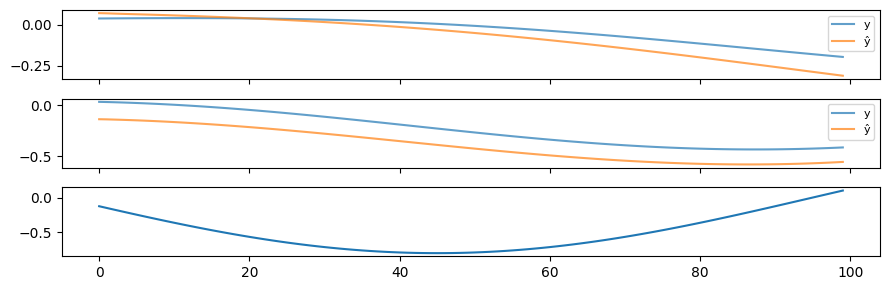

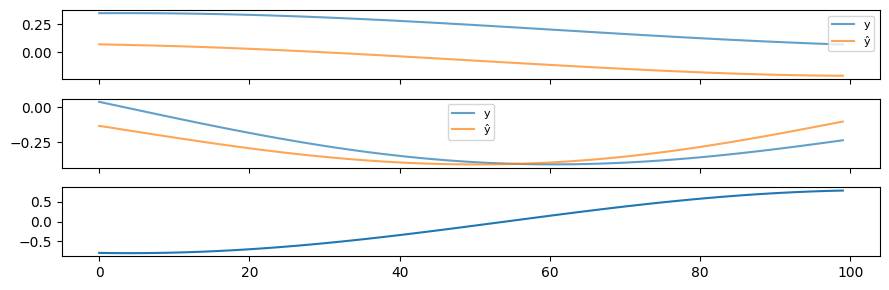

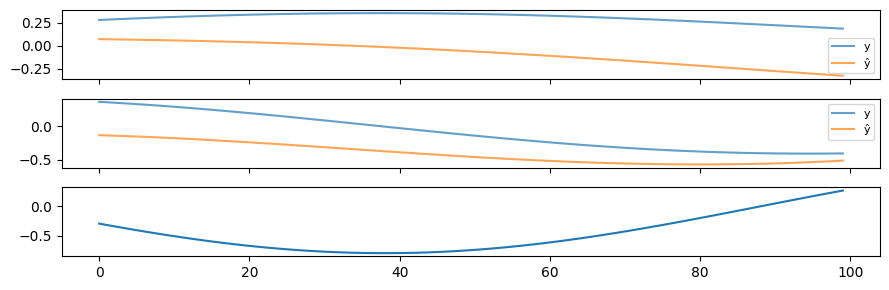

In [7]:
learn.show_results(max_n=3, ds_idx=1)

## Approach 2: PIRNN with Data + Physics

PIRNN (Physics-Informed RNN) combines data fitting with physics
constraints. It uses a dual-encoder architecture:

- A **SequenceEncoder** (diagnosis RNN) that processes an initialization
  window of measured data to estimate the system's hidden state
- A **StateEncoder** (MLP) that maps a single physical state vector
  directly to the RNN hidden state, enabling variable initial conditions
  at inference without needing a full initialization sequence

Two callbacks enforce physics:

- **`PhysicsLossCallback`**: computes the physics loss on actual training
  data batches
- **`CollocationPointsCB`**: computes the physics loss on randomly
  generated input signals for better generalization

Key parameters:

- **`init_sz=10`** -- number of timesteps used for initialization
  (shorter than FranSys since we have a StateEncoder as backup)
- **`attach_output=True`** -- enables prediction mode, where the model
  receives past outputs as additional input
- **`state_encoder_hidden=32`** -- hidden dimension of the StateEncoder
  MLP
- **`loss_weights`** -- relative importance of each physics loss
  component. `initial` is weighted 10x higher to anchor predictions to
  measured initial conditions.
- **`init_mode='state_encoder'`** -- tells the collocation callback to
  initialize the model via the StateEncoder with random physical states
- **`output_ranges`** -- physical ranges for random state generation,
  one (min, max) tuple per output channel

In [8]:
learn = PIRNNLearner(
    dls, init_sz=10, attach_output=True,
    rnn_type='gru', rnn_layer=1, hidden_size=20,
    state_encoder_hidden=32,
    loss_func=zero_loss, metrics=[fun_rmse],
)

# Physics on training data
learn.add_cb(PhysicsLossCallback(
    physics_loss_func=spring_damper_physics,
    weight=1.0,
    loss_weights={'physics': 1.0, 'derivative': 1.0, 'initial': 10.0},
    n_inputs=1,
))

# Physics on collocation points with StateEncoder initialization
learn.add_cb(CollocationPointsCB(
    generate_pinn_input=lambda bs, sl, dev: generate_excitation_signals(
        bs, sl, n_inputs=1, dt=DT, device=dev,
        amplitude_range=(0.5, 2.0), frequency_range=(0.1, 3.0),
    ),
    physics_loss_func=spring_damper_physics,
    weight=0.5,
    init_mode='state_encoder',
    output_ranges=[(-1.0, 1.0), (-2.0, 2.0)],
    num_workers=1,
))

learn.fit_flat_cos(10, 3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.370496,0.000000,0.171146,00:23
1,0.226303,0.000000,0.155191,00:21
2,0.210692,0.000000,0.144851,00:23
3,0.213829,0.000000,0.136745,00:22
4,0.209492,0.000000,0.129498,00:21
5,0.214141,0.000000,0.118807,00:21
6,0.202132,0.000000,0.108088,00:20
7,0.207725,0.000000,0.103824,00:19
8,0.210037,0.000000,0.091170,00:23
9,0.202462,0.000000,0.085965,00:21


## Approach 2: Results

The PIRNN model benefits from both data fitting and physics constraints.
The StateEncoder allows it to handle variable initial conditions.

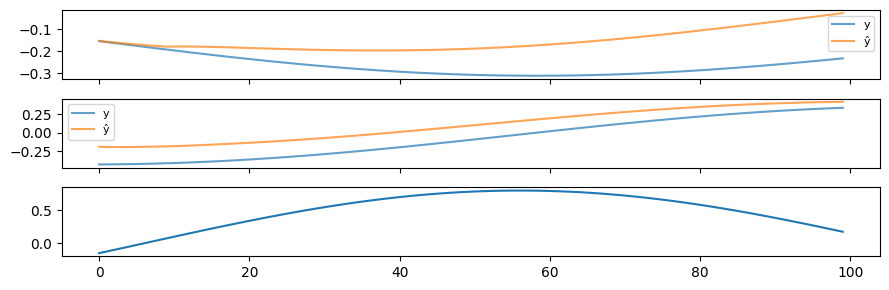

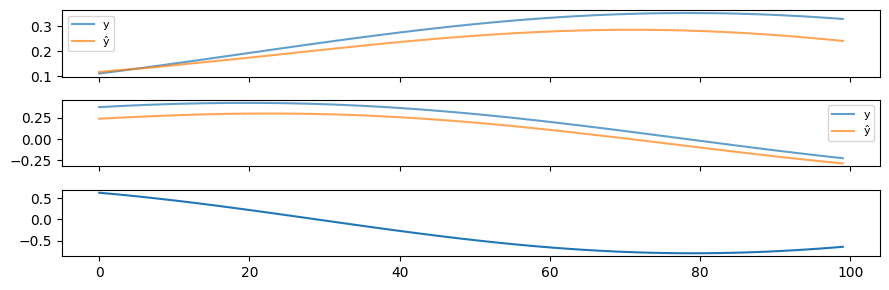

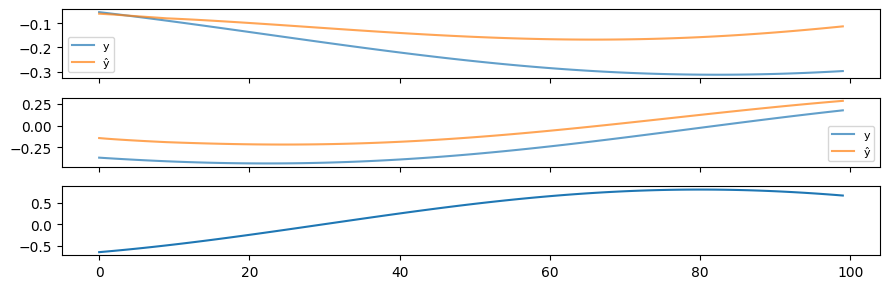

In [9]:
learn.show_results(max_n=3, ds_idx=1)

## Key Takeaways

- **PINNs embed physical laws directly into the training process** via
  custom loss functions that penalize ODE residuals.
- **Approach 1 (collocation only)** creates a physics surrogate model
  with no measured data -- useful when the governing equations are known
  but data is unavailable.
- **Approach 2 (PIRNN)** combines data fitting with physics constraints
  for better accuracy and generalization.
- **`zero_loss`** is used when physics is the only training signal -- it
  returns 0 so the physics callbacks provide 100% of the gradient.
- **`PhysicsLossCallback`** enforces physics on real training data;
  **`CollocationPointsCB`** enforces physics on randomly generated
  excitation signals for broader coverage.
- **`StateEncoder`** maps a physical state vector to an RNN hidden state,
  enabling variable initial conditions without a full initialization
  sequence.
- PINNs are especially useful when **data is scarce but the governing
  equations are known**.